FRAP Inclusion Shape Analysis

Code used to process spermine FRAP images and measure shape features

In [1]:
# cell pose is machine learning model for segmenting cells
from cellpose import models, utils, io

# for clearing jpynb output
from IPython.display import clear_output

# import necessary libraries
from scipy.ndimage import binary_fill_holes
from mpl_toolkits.mplot3d import Axes3D

import math
import skimage
import numpy as np
from czifile import CziFile
from skimage import filters, morphology, segmentation
import numpy as np
from skimage.measure import regionprops
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.measure import label, regionprops
from skimage.io import imread
from skimage.measure import label
import czifile as czi
import pandas as pd
from skimage.filters import gaussian, threshold_otsu, sobel, median
from skimage.filters import threshold_otsu
from skimage import exposure
from skimage import morphology
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage.morphology import binary_dilation, disk
from os import listdir
from os.path import isfile, join

In [2]:
import czifile

def quantify_inclusion_shape_frap(file, folder_path):
        image_path = fr'{folder_path}\{file}'

        # read in the czi file in as an array, and clean off the metadata
        image = czifile.imread(image_path)

        image_squeezed = np.squeeze(image)
        # take just the first frame of the time course image
        green_channel = image_squeezed[0, :, :]

        # adjust the contrast of the image via sigmoid
        contrast_adjusted_green = exposure.adjust_sigmoid(green_channel, cutoff=0.30)
        # normalize the contrast of the inclusions
        contrast_adjusted_green_normalized = (contrast_adjusted_green - contrast_adjusted_green.min()) / (contrast_adjusted_green.max() - contrast_adjusted_green.min())    
        threshold_value_inclusion = 0.25
        # create a binary mask
        inclusion_thresholded = contrast_adjusted_green_normalized > threshold_value_inclusion

        inclusion_thresholded_clean = skimage.morphology.remove_small_objects(inclusion_thresholded, min_size=57)

        inclusion_thresholded_clean = skimage.segmentation.clear_border(inclusion_thresholded_clean)
        # label the inclusions
        green_labeled = skimage.measure.label(inclusion_thresholded_clean)
        # remove objects that touch the border of the image
        green_labeled_clean = skimage.segmentation.clear_border(green_labeled)

        # take region properties from each labeled region
        # can also take the contours of the boundary
        shape_props = skimage.measure.regionprops_table(
                green_labeled_clean,
                properties=('area', 'perimeter', 'solidity', 'bbox', 'euler_number'))
        shape_props_df = pd.DataFrame(shape_props)

        fig, axes = plt.subplots(1, 2, figsize=(15, 9))
        # Plot each frame
        axes[0].imshow(green_channel)
        axes[0].set_title('green channel')
        axes[0].axis('off')

        axes[1].imshow(green_labeled_clean)
        axes[1].set_title('labeled and cleaned green')
        axes[1].axis('off')
        plt.show()

        
        # calculate the circularity of each inclusion
        shape_props_df['circularity'] = (4 * math.pi * shape_props_df['area']) / (shape_props_df['perimeter']**2)

        # add two more measures of shape
        elongation_list = []
        rectangularity_list = []
        # calculate the elongation of each image
        for i in range(len(shape_props_df)):
                #(min_row, min_col, max_row, max_col)
                min_row = shape_props_df.loc[i, 'bbox-0']
                min_col = shape_props_df.loc[i, 'bbox-1']
                max_row = shape_props_df.loc[i, 'bbox-2']
                max_col = shape_props_df.loc[i, 'bbox-3']

                major_axis = max((max_row-min_row), (max_col - min_col))
                minor_axis = min((max_row-min_row), (max_col - min_col))
                # elongation is calcualted with width over length, so closer to zero means it is longer
                elongation = minor_axis / major_axis
                elongation_list.append(elongation)
                # rectangularity is the area of the object divided by the arae of it's bounding rectangle
                rectangularity = shape_props_df.loc[i, 'area'] / (major_axis * minor_axis)
                rectangularity_list.append(rectangularity)

        # add the two new measures
        shape_props_df['elongation'] = elongation_list
        shape_props_df['rectangularity'] = rectangularity_list
        # rename the bbox bound columnds
        shape_props_df_new = shape_props_df.rename({'bbox-0' : 'bbox min row', 'bbox-1' : 'bbox min col', 'bbox-2' : 'bbox max row', 'bbox-3' : 'bbox max col'}, axis=1)
        # sort by inclusion size and label accordingly
        shape_props_df_sorted = (shape_props_df_new.sort_values('area', ascending=False)).reset_index(drop=True)
        shape_props_df_sorted.insert(loc = 0, column='inclusion', value=list(range(1, len(shape_props_df_sorted)+1)))
        shape_props_df_sorted.insert(loc=0, column='image', value=file)

        display(shape_props_df_sorted.loc[0, ['image', 'elongation', 'rectangularity', 'circularity']])

        return shape_props_df_sorted



c:\Users\bs1250\Box\LAB\Lab Folder\WGCNA_Ben\Analysis\final_code_for_github\image_analysis\inclusion_shape_analysis


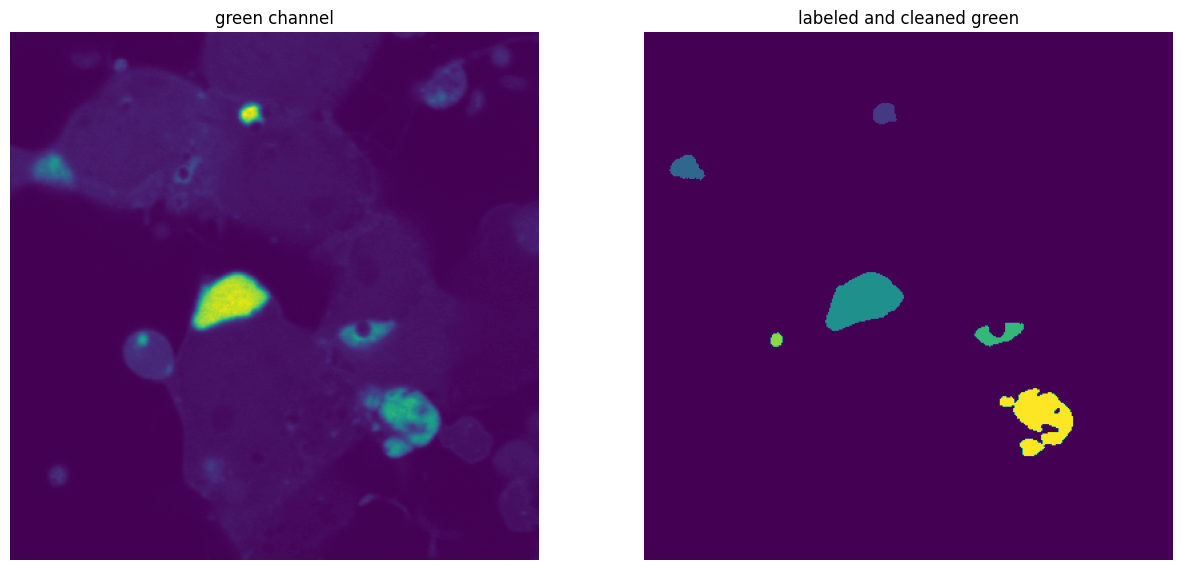

image             4000_spermine_Inclusion_03.czi
elongation                              0.745763
rectangularity                            0.6302
circularity                             0.738458
Name: 0, dtype: object

,image,inclusion,area,perimeter,solidity,bbox min row,bbox min col,bbox max row,bbox max col,euler_number,circularity,elongation,rectangularity
0,4000_spermine_Inclusion_03.czi,1,1636.0,166.852814,0.953380,181,136,225,195,1,0.738458,0.745763,0.630200
1,4000_spermine_Inclusion_03.czi,2,1415.0,275.178716,0.721571,268,267,319,322,0,0.234821,0.927273,0.504456
2,4000_spermine_Inclusion_03.czi,3,334.0,103.740115,0.727669,219,248,237,285,1,0.389998,0.486486,0.501502
3,4000_spermine_Inclusion_03.czi,4,330.0,75.254834,0.914127,93,19,112,46,1,0.732243,0.703704,0.643275
4,4000_spermine_Inclusion_03.czi,5,224.0,55.213203,0.941176,54,172,70,190,1,0.923362,0.888889,0.777778
5,4000_spermine_Inclusion_03.czi,6,76.0,30.142136,0.950000,226,95,237,104,1,1.051176,0.818182,0.767677


In [8]:
# find the size of inclusions that make circularity larger than 1
frap_analysis_folder = 'inclusion_shape_images'
images_to_analyze = [f for f in listdir(frap_analysis_folder) if isfile(join(frap_analysis_folder, f))]

df_list = []
for i in images_to_analyze:
    single_image_result = quantify_inclusion_shape_frap(file=i, folder_path=frap_analysis_folder)
    df_list.append(single_image_result)

total_df = pd.concat(df_list)
display(total_df)



